# Sentinel Hub Process API

In this example notebook we show how to use Sentinel Hub Process API to download satellite imagery. We describe how to use various parameters and configurations to obtain either processed products or raw band data. For more information about the service please check the [official service documentation](https://docs.sentinel-hub.com/api/latest/api/process/).

## Prerequisites

### Credentials

Process API requires Sentinel Hub account. Please check [configuration instructions](https://sentinelhub-py.readthedocs.io/en/latest/configure.html) about how to set up your Sentinel Hub credentials.

In [65]:
from sentinelhub import SHConfig

config = SHConfig()

config.instance_id = "my-instance-id"
config.sh_client_id = "788b87e4-6187-40c4-9a0a-73f4865de1f5"
config.sh_client_secret = "Y&eVJ##C>)<9jkRkb9PhE*^}hN48hJ|v0V<BAAaD"
config.save()

print(config)

if not config.sh_client_id or not config.sh_client_secret:
    print("Warning! To use Process API, please provide the credentials (OAuth client ID and client secret).")

{
  "instance_id": "**********e-id",
  "sh_client_id": "********************************e1f5",
  "sh_client_secret": "************************************AAaD",
  "sh_base_url": "https://services.sentinel-hub.com",
  "sh_auth_base_url": "https://services.sentinel-hub.com",
  "geopedia_wms_url": "https://service.geopedia.world",
  "geopedia_rest_url": "https://www.geopedia.world/rest",
  "aws_access_key_id": "",
  "aws_secret_access_key": "",
  "aws_session_token": "",
  "aws_metadata_url": "https://roda.sentinel-hub.com",
  "aws_s3_l1c_bucket": "sentinel-s2-l1c",
  "aws_s3_l2a_bucket": "sentinel-s2-l2a",
  "opensearch_url": "http://opensearch.sentinel-hub.com/resto/api/collections/Sentinel2",
  "max_wfs_records_per_query": 100,
  "max_opensearch_records_per_query": 500,
  "max_download_attempts": 4,
  "download_sleep_time": 5.0,
  "download_timeout_seconds": 120.0,
  "number_of_download_processes": 1
}


###  Imports 

In [66]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [67]:
import datetime
import os

import matplotlib.pyplot as plt
import numpy as np

from sentinelhub import (
    CRS,
    BBox,
    DataCollection,
    DownloadRequest,
    MimeType,
    MosaickingOrder,
    SentinelHubDownloadClient,
    SentinelHubRequest,
    bbox_to_dimensions,
)

# The following is not a package. It is a file utils.py which should be in the same folder as this notebook.
from utils import plot_image

### Setting area of interest

We will download Sentinel-2 imagery of [Betsiboka Estuary](https://en.wikipedia.org/wiki/Betsiboka_River) such as the one shown below (taken by Sentinel-2 on 2017-12-15):

![title](data/wms_TRUE_COLOR_EPSG4326_-16.15_46.16_-15.58_46.51_2017-12-15T07-12-03_512X856.png)

The bounding box in `WGS84` coordinate system is `[46.16, -16.15, 46.51, -15.58]` (longitude and latitude coordinates of lower left and upper right corners). You can get the bbox for a different area at the [bboxfinder](http://bboxfinder.com/) website.

All requests require bounding box to be given as an instance of `sentinelhub.geometry.BBox` with corresponding Coordinate Reference System (`sentinelhub.constants.CRS`). In our case it is in _WGS84_ and we can use the predefined _WGS84_ coordinate reference system from `sentinelhub.constants.CRS`.

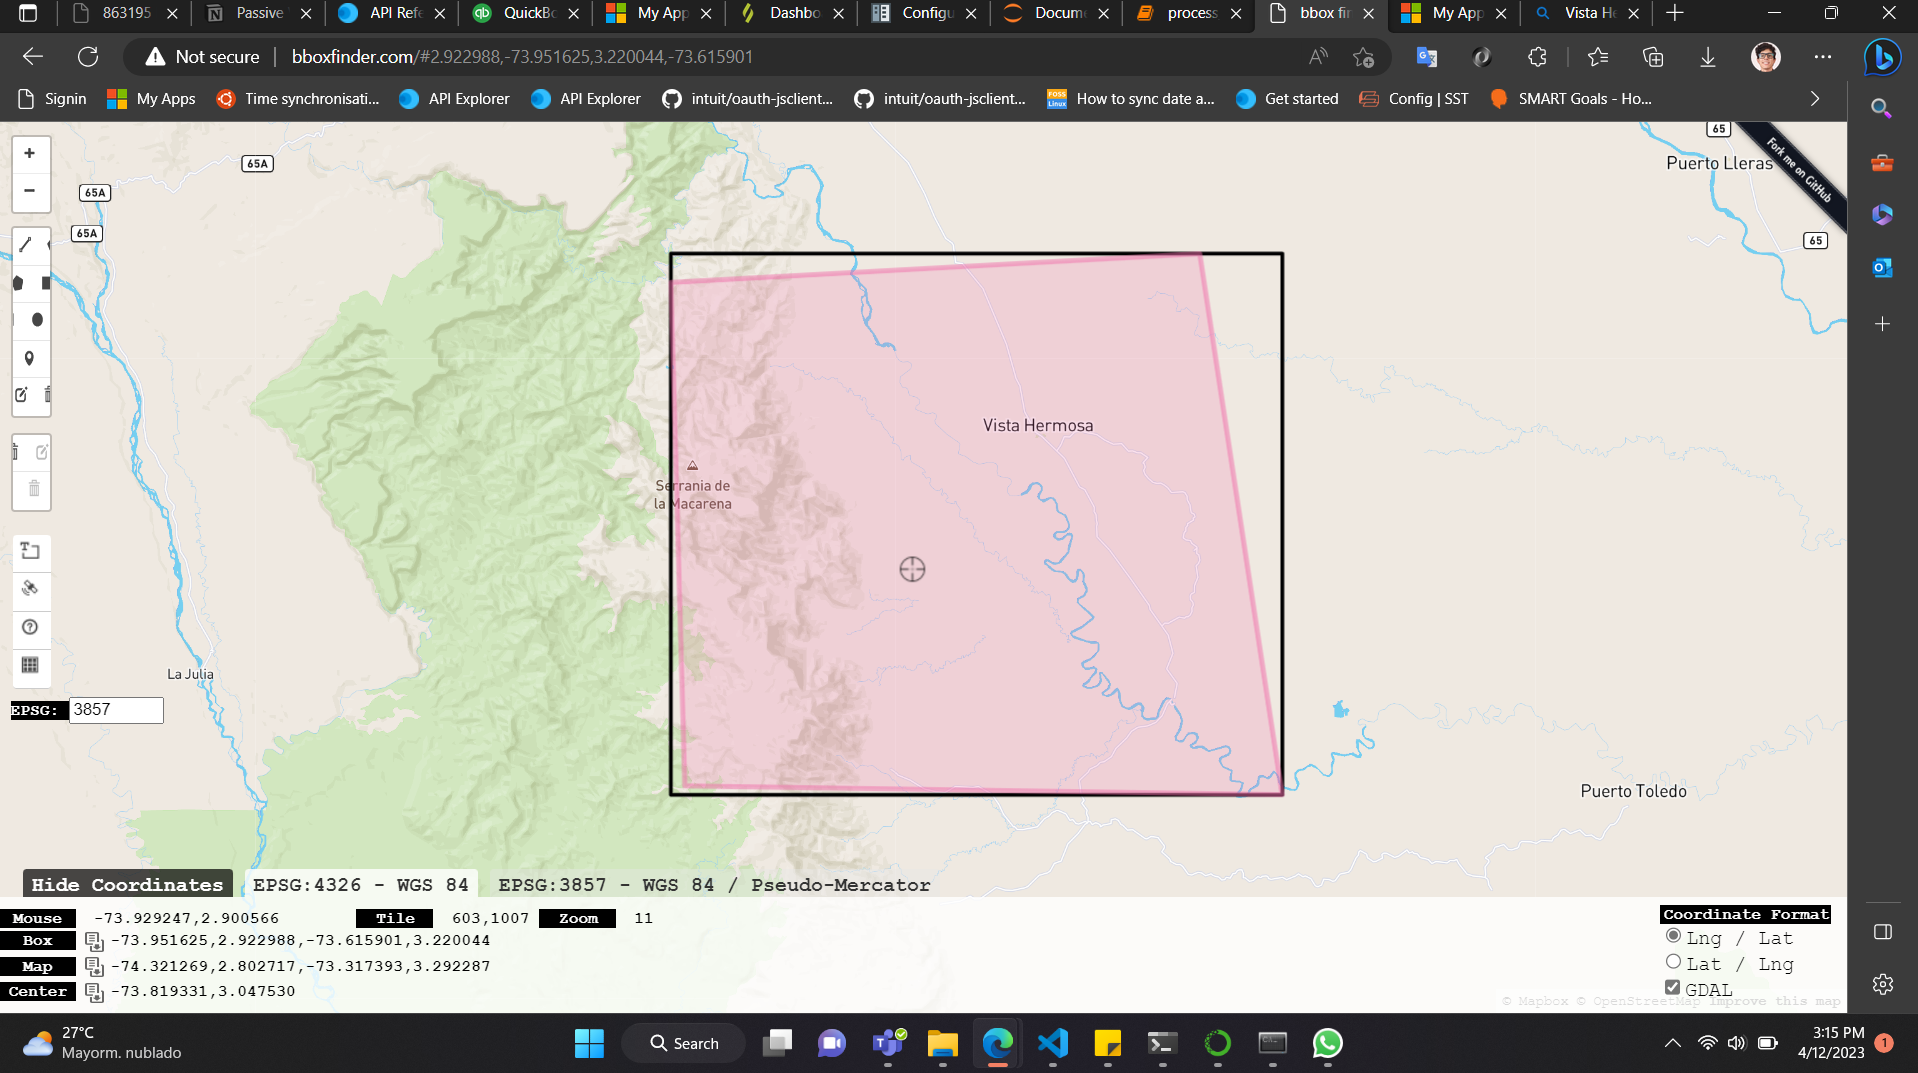

In [72]:
betsiboka_coords_wgs84 = (-73.951625,2.922988,-73.615901,3.220044) # Cuando es grande se daña

When the bounding box bounds have been defined, you can initialize the `BBox` of the area of interest. Using the `bbox_to_dimensions` utility function, you can provide the desired resolution parameter of the image in meters and obtain the output image shape.

In [73]:
resolution = 60
betsiboka_bbox = BBox(bbox=betsiboka_coords_wgs84, crs=CRS.WGS84)
betsiboka_size = bbox_to_dimensions(betsiboka_bbox, resolution=resolution)

print(f"Image shape at {resolution} m resolution: {betsiboka_size} pixels")

Image shape at 60 m resolution: (621, 548) pixels


## Example 1: True color (PNG) on a specific date

We build the request according to the [API Reference](https://docs.sentinel-hub.com/api/latest/reference/), using the `SentinelHubRequest` class. Each Process API request also needs an [evalscript](https://docs.sentinel-hub.com/api/latest/#/Evalscript/V3/README).


The information that we specify in the `SentinelHubRequest` object is: 

 * an evalscript,
 * a list of input data collections with time interval,
 * a format of the response,
 * a bounding box and it's size (size or resolution).

The evalscript in the example is used to select the appropriate bands. We return the RGB (B04, B03, B02) Sentinel-2 L1C bands.

The image from Jun 12th 2020 is downloaded. Without any additional parameters in the evalscript, the downloaded data will correspond to reflectance values in `UINT8` format (values in 0-255 range).

In [147]:
evalscript_true_color = """
    //VERSION=3

    function setup() {
        return {
            input: [{
                bands: ["B02", "B03", "B04"]
            }],
            output: {
                bands: 3
            }
        };
    }

    function evaluatePixel(sample) {
        return [sample.B04, sample.B03, sample.B02];
    }
"""

request_true_color = SentinelHubRequest(
    evalscript=evalscript_true_color,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L2A, #data_collection=DataCollection.SENTINEL2_L1C,
            time_interval=("2022-01-29", "2022-01-30"), #time_interval=("2020-06-12", "2020-06-13"),
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.PNG)],
    bbox=betsiboka_bbox,
    size=betsiboka_size,
    config=config,
)

In [148]:
true_color_imgs = request_true_color.get_data()

The method `get_data()` will always return a list of length 1 with the available image from the requested time interval in the form of numpy arrays. 

In [149]:
print(f"Returned data is of type = {type(true_color_imgs)} and length {len(true_color_imgs)}.")
print(f"Single element in the list is of type {type(true_color_imgs[-1])} and has shape {true_color_imgs[-1].shape}")

Returned data is of type = <class 'list'> and length 1.
Single element in the list is of type <class 'numpy.ndarray'> and has shape (548, 621, 3)


Image type: uint8


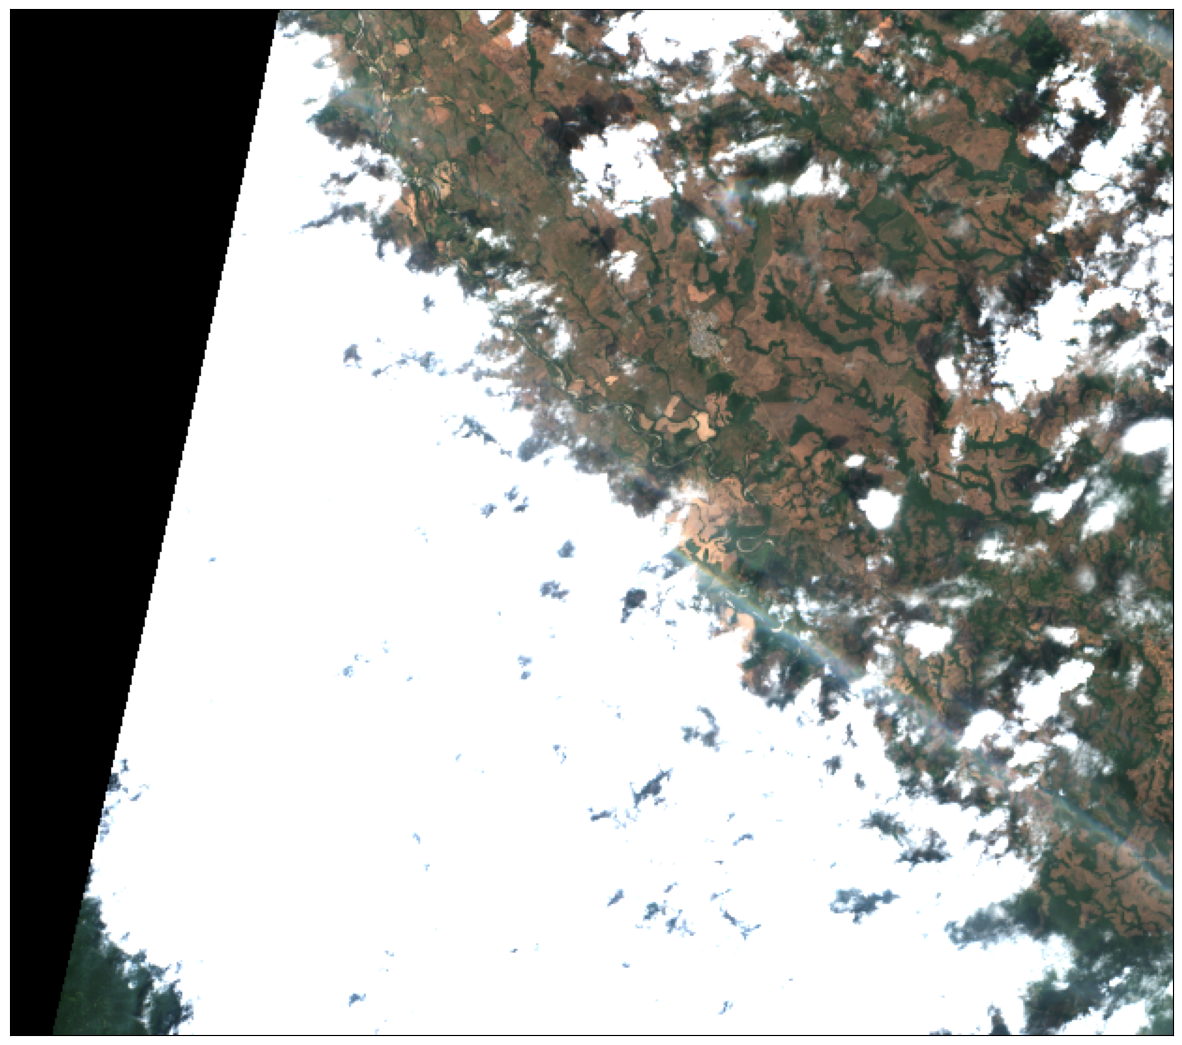

In [150]:
image = true_color_imgs[0]
print(f"Image type: {image.dtype}")

# plot function
# factor 1/255 to scale between 0-1
# factor 3.5 to increase brightness
plot_image(image, factor=3.5 / 255, clip_range=(0, 1))

### Example 1.1 Adding cloud mask data

It is also possible to obtain cloud masks when requesting Sentinel-2 data by using the cloud mask band (`CLM`) or the cloud probabilities band (`CLP`). More info [here](https://docs.sentinel-hub.com/api/latest/#/API/data_access?id=cloud-masks-and-cloud-probabilities).  

The factor for increasing the image brightness can already be provided in the evalscript.

In [110]:
evalscript_clm = """
//VERSION=3
function setup() {
  return {
    input: ["B02", "B03", "B04", "CLM"],
    output: { bands: 3 }
  }
}

function evaluatePixel(sample) {
  if (sample.CLM == 1) {
    return [0.75 + sample.B04, sample.B03, sample.B02]
  }
  return [3.5*sample.B04, 3.5*sample.B03, 3.5*sample.B02];
}
"""

request_true_color = SentinelHubRequest(
    evalscript=evalscript_clm,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L1C,
            time_interval=("2022-01-30", "2022-01-31"),
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.PNG)],
    bbox=betsiboka_bbox,
    size=betsiboka_size,
    config=config,
)

In [111]:
data_with_cloud_mask = request_true_color.get_data()

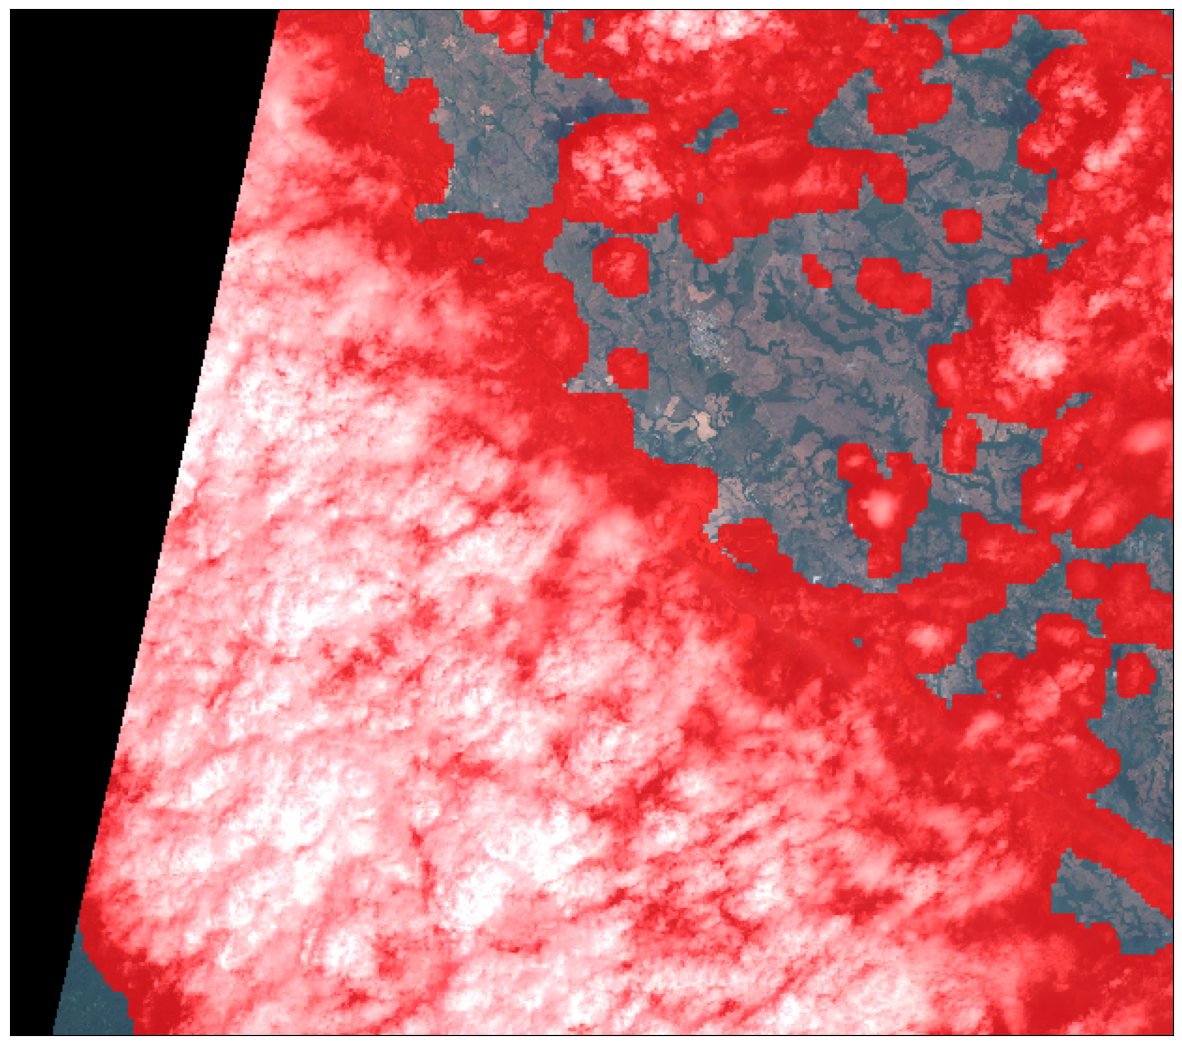

In [112]:
plot_image(data_with_cloud_mask[0], factor=1 / 255)

## Example 2: True color mosaic of least cloudy acquisitions  

The `SentinelHubRequest` automatically creates a mosaic from all available images in the given time interval. By default, the `mostRecent` mosaicking order is used. More information available [here](https://docs.sentinel-hub.com/api/latest/#/data/Sentinel-2-L2A?id=mosaickingorder).

In this example we will provide a month long interval, order the images w.r.t. the cloud coverage on the tile level (`leastCC` parameter), and mosaic them in the specified order.

In [113]:
request_true_color = SentinelHubRequest(
    evalscript=evalscript_true_color,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L1C,
            time_interval=("2022-01-30", "2022-01-31"), #time_interval=("2020-06-01", "2020-06-30"),
            mosaicking_order=MosaickingOrder.LEAST_CC,
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.PNG)],
    bbox=betsiboka_bbox,
    size=betsiboka_size,
    config=config,
)

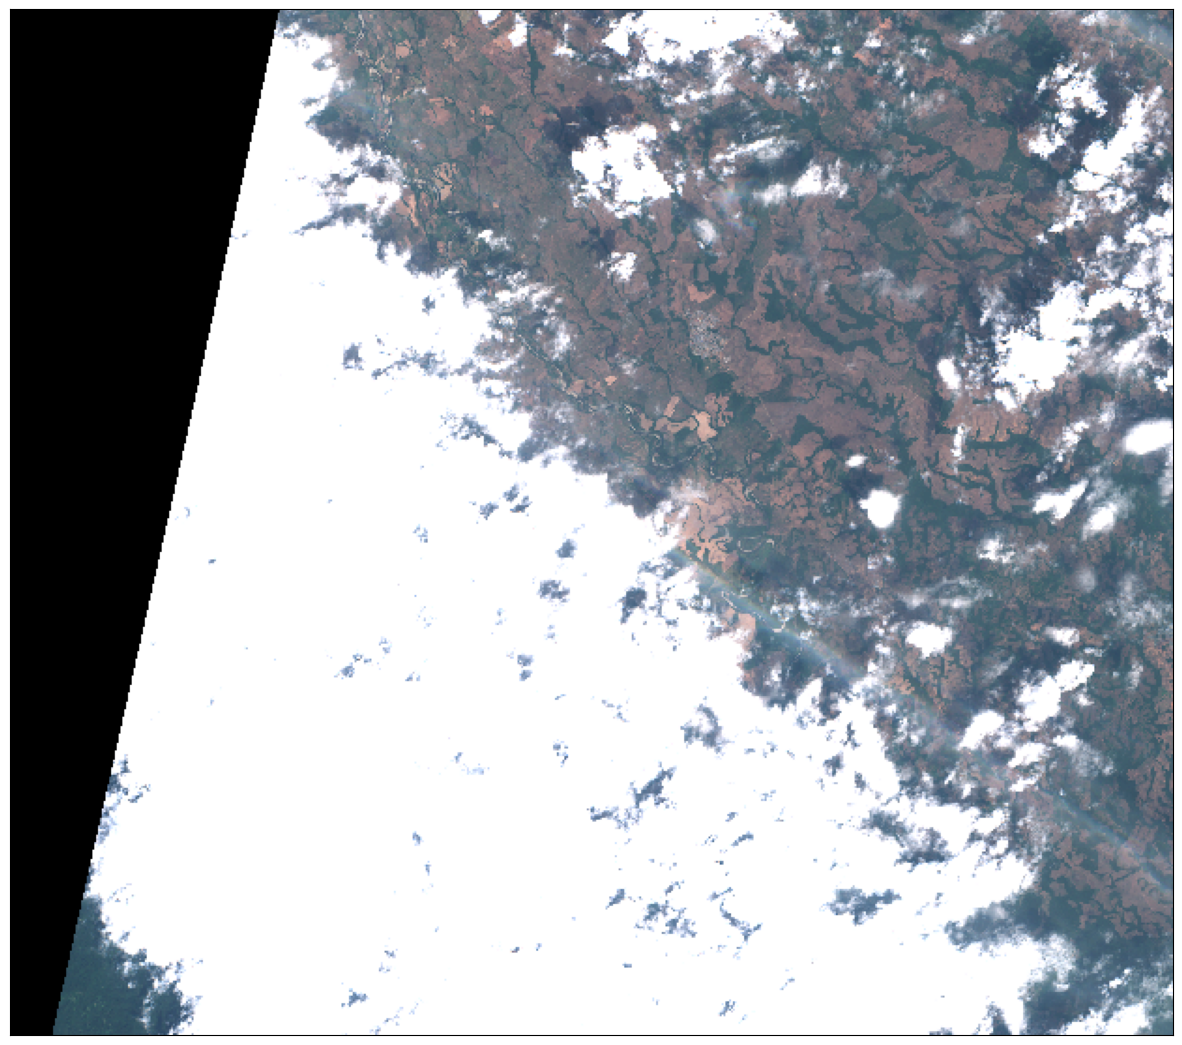

In [114]:
plot_image(request_true_color.get_data()[0], factor=3.5 / 255, clip_range=(0, 1))

## Example 4: Save downloaded data to disk and read it from disk

All downloaded data can be saved to disk and later read from it. Simply specify the location on disk where data should be saved (or loaded from) via the `data_folder` argument of the request's constructor. When executing the request's `get_data` method, set the argument `save_data` to `True`.

This also means that in all the future requests for data, the request will first check the provided location if the data is already there, unless you explicitly demand to redownload the data.

In [ ]:
request_all_bands = SentinelHubRequest(
    data_folder="test_dir",
    evalscript=evalscript_all_bands,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L1C,
            time_interval=("2020-06-01", "2020-06-30"),
            mosaicking_order=MosaickingOrder.LEAST_CC,
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
    bbox=betsiboka_bbox,
    size=betsiboka_size,
    config=config,
)

In [ ]:
%%time
all_bands_img = request_all_bands.get_data(save_data=True)

In [ ]:
print(
    "The output directory has been created and a tiff file with all 13 bands was saved into the following structure:\n"
)

for folder, _, filenames in os.walk(request_all_bands.data_folder):
    for filename in filenames:
        print(os.path.join(folder, filename))

In [ ]:
%%time
# try to re-download the data
all_bands_img_from_disk = request_all_bands.get_data()

In [ ]:
%%time
# force the redownload
all_bands_img_redownload = request_all_bands.get_data(redownload=True)

### Example 4.1: Save downloaded data directly to disk

The `get_data` method returns a list of numpy arrays and can save the downloaded data to disk, as we have seen in the previous example. Sometimes it is convenient to just save the data directly to disk. You can do that by using `save_data` method instead.

In [ ]:
%%time
request_all_bands.save_data()

In [ ]:
print(
    "The output directory has been created and a tiff file with all 13 bands was saved into the following structure:\n"
)

for folder, _, filenames in os.walk(request_all_bands.data_folder):
    for filename in filenames:
        print(os.path.join(folder, filename))

## Example 5: Other Data Collections

The `sentinelhub-py` package supports various data collections. The example below is shown for one of them, but the process is the same for all of them.


<div class="alert alert-info">

<b>Note:</b>
    
For more examples and information check the [tutorial about data collections](./data_collections.ipynb) and [Sentinel Hub documentation about data collections](https://docs.sentinel-hub.com/api/latest/#/data/).
</div>

In [ ]:
print("Supported DataCollections:\n")
for collection in DataCollection.get_available_collections():
    print(collection)

For this example let's download the digital elevation model data (DEM). The process is similar as before, we just provide the evalscript and create the request. More data on the `DEM` data collection is available [here](https://docs.sentinel-hub.com/api/latest/#/data/DEM). `DEM` values are in meters and can be negative for areas which lie below sea level, so it is recommended to set the output format in your evalscript to `FLOAT32`.

In [ ]:
evalscript_dem = """
//VERSION=3
function setup() {
  return {
    input: ["DEM"],
    output:{
      id: "default",
      bands: 1,
      sampleType: SampleType.FLOAT32
    }
  }
}

function evaluatePixel(sample) {
  return [sample.DEM]
}
"""

In [ ]:
dem_request = SentinelHubRequest(
    evalscript=evalscript_dem,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.DEM,
            time_interval=("2020-06-12", "2020-06-13"),
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
    bbox=betsiboka_bbox,
    size=betsiboka_size,
    config=config,
)

In [ ]:
dem_data = dem_request.get_data()

In [ ]:
# Plot DEM map
# vmin = 0; cutoff at sea level (0 m)
# vmax = 120; cutoff at high values (120 m)
plot_image(dem_data[0], factor=1.0, cmap=plt.cm.Greys_r, vmin=0, vmax=120)

## Example 6 : Multi-response request type

Process API enables downloading multiple files in one response, packed together in a TAR archive.

We will get the same image as before, download in the form of digital numbers (DN) as a UINT16 TIFF file. Along with the image we will download the `inputMetadata` which contains the normalization factor value in a JSON format. 

After the download we will be able to convert the `INT16` digital numbers to get the `FLOAT32` reflectances.

In [ ]:
evalscript = """
    //VERSION=3

    function setup() {
        return {
            input: [{
                bands: ["B02", "B03", "B04"],
                units: "DN"
            }],
            output: {
                bands: 3,
                sampleType: "INT16"
            }
        };
    }

    function updateOutputMetadata(scenes, inputMetadata, outputMetadata) {
        outputMetadata.userData = { "norm_factor":  inputMetadata.normalizationFactor }
    }

    function evaluatePixel(sample) {
        return [sample.B04, sample.B03, sample.B02];
    }
"""

request_multitype = SentinelHubRequest(
    evalscript=evalscript,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L1C,
            time_interval=("2020-06-01", "2020-06-30"),
            mosaicking_order=MosaickingOrder.LEAST_CC,
        )
    ],
    responses=[
        SentinelHubRequest.output_response("default", MimeType.TIFF),
        SentinelHubRequest.output_response("userdata", MimeType.JSON),
    ],
    bbox=betsiboka_bbox,
    size=betsiboka_size,
    config=config,
)

In [ ]:
# print out information
multi_data = request_multitype.get_data()[0]
multi_data.keys()

In [ ]:
# normalize image
img = multi_data["default.tif"]
norm_factor = multi_data["userdata.json"]["norm_factor"]

img_float32 = img * norm_factor

In [ ]:
plot_image(img_float32, factor=3.5, clip_range=(0, 1))

## Example 7 : Raw dictionary request

All requests so far were built with some helper functions. We can also construct a raw dictionary as defined in the [API Reference](https://docs.sentinel-hub.com/api/latest/reference/), without these helper functions, so we have full control over building the request body.

In [ ]:
request_raw_dict = {
    "input": {
        "bounds": {"properties": {"crs": betsiboka_bbox.crs.opengis_string}, "bbox": list(betsiboka_bbox)},
        "data": [
            {
                "type": "S2L1C",
                "dataFilter": {
                    "timeRange": {"from": "2020-06-01T00:00:00Z", "to": "2020-06-30T00:00:00Z"},
                    "mosaickingOrder": "leastCC",
                },
            }
        ],
    },
    "output": {
        "width": betsiboka_size[0],
        "height": betsiboka_size[1],
        "responses": [{"identifier": "default", "format": {"type": MimeType.TIFF.get_string()}}],
    },
    "evalscript": evalscript_true_color,
}

In [ ]:
# create request
download_request = DownloadRequest(
    request_type="POST",
    url="https://services.sentinel-hub.com/api/v1/process",
    post_values=request_raw_dict,
    data_type=MimeType.TIFF,
    headers={"content-type": "application/json"},
    use_session=True,
)

# execute request
client = SentinelHubDownloadClient(config=config)
img = client.download(download_request)

In [ ]:
plot_image(img, factor=3.5 / 255, clip_range=(0, 1))

## Example 8 : Multiple timestamps data

It is possible to construct some logic in order to return data for multiple timestamps. By defining the `time_interval` parameter and some logic of splitting it, it is possible to create an SH reques per each "time slot" and then download the data from all the requests with the `SentinelHubDownloadClient` in `sentinelhub-py`. In this example we will create least cloudy monthly images for the year 2019.

However, this is already a functionality built on top of this SH API package. We have extended the support for such usage in our package [eo-learn](https://github.com/sentinel-hub/eo-learn). We recommend to use `eo-learn` for more complex cases where you need multiple timestamps or high-resolution data for larger areas.

In [ ]:
start = datetime.datetime(2019, 1, 1)
end = datetime.datetime(2019, 12, 31)
n_chunks = 13
tdelta = (end - start) / n_chunks
edges = [(start + i * tdelta).date().isoformat() for i in range(n_chunks)]
slots = [(edges[i], edges[i + 1]) for i in range(len(edges) - 1)]

print("Monthly time windows:\n")
for slot in slots:
    print(slot)

In [ ]:
def get_true_color_request(time_interval):
    return SentinelHubRequest(
        evalscript=evalscript_true_color,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=DataCollection.SENTINEL2_L1C,
                time_interval=time_interval,
                mosaicking_order=MosaickingOrder.LEAST_CC,
            )
        ],
        responses=[SentinelHubRequest.output_response("default", MimeType.PNG)],
        bbox=betsiboka_bbox,
        size=betsiboka_size,
        config=config,
    )

In [ ]:
# create a list of requests
list_of_requests = [get_true_color_request(slot) for slot in slots]
list_of_requests = [request.download_list[0] for request in list_of_requests]

# download data with multiple threads
data = SentinelHubDownloadClient(config=config).download(list_of_requests, max_threads=5)

In [ ]:
# some stuff for pretty plots
ncols = 4
nrows = 3
aspect_ratio = betsiboka_size[0] / betsiboka_size[1]
subplot_kw = {"xticks": [], "yticks": [], "frame_on": False}

fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(5 * ncols * aspect_ratio, 5 * nrows), subplot_kw=subplot_kw)

for idx, image in enumerate(data):
    ax = axs[idx // ncols][idx % ncols]
    ax.imshow(np.clip(image * 2.5 / 255, 0, 1))
    ax.set_title(f"{slots[idx][0]}  -  {slots[idx][1]}", fontsize=10)

plt.tight_layout()